In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as mt
from metpy.interpolate import interpolate_to_points
import scipy.optimize as spo
import time 
from joblib import Parallel, delayed
import glob
from os import walk

In [2]:
# creating the pulse field

def gen_field(dur_max, dur_step):
    pdur_i0 = ppau_i0 = np.arange(0, dur_max, dur_step)
    pdur_j, ppau_j = np.meshgrid(pdur_i0, ppau_i0)
    return pdur_j, ppau_j


In [3]:
#Plotting the data

def plot_field(pdur, ppau, res):
    plt.pcolor(pdur, ppau, res, cmap='Reds')
    plt.xlim(0, np.max(pdur))
    plt.ylim(0, np.max(ppau))
    plt.colorbar(label='Phonotaxis')
    plt.xlabel('Pulse [ms]')
    plt.ylabel('Pause [ms]')
    plt.show()

In [4]:
#filtering data to have similar chirp structure and eliminating redundancies in pulse pause and duration

def filter_data(x, dur_max):
    pd_df = x
    
    #finding frequency of each chirp duration
    x = np.array(pd_df.CDUR)
    x = x.astype(int)
    (uniq, freq) = (np.unique(x, return_counts=True))
    xa = np.array([uniq,freq])

    #finding the bracket of 61 values with the most data points
    if (np.max(xa[0]) - np.min(xa[0])) > 60: #Checking if the range of available points exceeds interested bracket size
        jo = np.zeros(np.max(xa[0]))
        jo[xa[0]-1] = freq
        jo2 = []
        for i in range(30,len(jo)-30):
            jo2.append([i, np.sum(jo[i-30:i+30])])
        jo2 = np.array(jo2).T
        j = np.where(jo2 == np.max(jo2[1]))
        val = j[1][1] + 31

        #filtering down to values in the bracket calculated above
        x = pd_df.CDUR
        x1 = x>=(val-30)
        xa = pd_df[x1]
        x2 = xa.CDUR<=(val+30)
        xb = xa[x2]
    
    else: 
        xb = pd_df
    
    #repeating the same procedure for the values in chirp pause
    pd_df = xb
    x = np.array(pd_df.CPAU)
    x = x.astype(int)
    (uniq, freq) = (np.unique(x, return_counts=True))
    xa = np.array([uniq,freq])

    if (np.max(xa[0]) - np.min(xa[0])) > 60:
        jo = np.zeros(np.max(xa[0]))
        jo[xa[0]-1] = freq
        jo2 = []
        for i in range(30,len(jo)-30):
            jo2.append([i, np.sum(jo[i-30:i+30])])
        jo2 = np.array(jo2).T
        j = np.where(jo2 == np.max(jo2[1]))
        val = j[1][1] + 31

        x = pd_df.CPAU
        x1 = x>=(val-30)
        xa = pd_df[x1]
        x2 = xa.CPAU<=(val+30)
        xb1 = xa[x2]
    
    else: 
        xb1 = xb

    #averaging the duplicates
    dfa = pd.DataFrame([xb1.PDUR, xb1.PPAU, xb1.rXY]).T
    dfx = dfa.groupby(['PPAU', 'PDUR']).mean().reset_index()
    
    #filtering for values under the maximum duration specified
    check = dfx<=dur_max
    df_c = np.all(check,1)
    dfx = dfx[df_c]
    
    dfx = np.array([dfx.PDUR, dfx.PPAU, dfx.rXY]).T
    
    dur_max = np.max([np.max(dfx.T[0]), np.max(dfx.T[1])])
    print(dur_max)
    dur_max = int(dur_max*1.25)
    dur_steps = int(np.sqrt((dur_max**2 * 16)/2500))/4
    print(dur_steps)
    
    edg = [[0,0,0], [0, dur_max, 0], [dur_max, dur_max, 0], [dur_max,0,0]] #initializing origin to zero (for smooth interpolation purposes)
    dfx = np.append(dfx, edg, axis = 0) 
    dfx = dfx.T
    
    #plotting for verifying of data points
    plt.plot(dfx[0], dfx[1], 'o')
    plt.xlim(0, dur_max)
    plt.ylim(0, dur_max)
    plt.show()
    return dfx, dur_max, dur_steps


In [5]:
#Importing data from file

def import_data(species, dur_max):
    
    pd_df = species
    df, dur_max, dur_step = filter_data(pd_df, dur_max)    
    
    pdur = df[0]
    ppau = df[1]
    phonotaxis = df[2]

    np.random.seed(10)
    # need to jitter data points slightly for interp to work - probably a bug in metpy
    points = np.array([pdur + np.random.randn(*pdur.shape)/10000000, ppau + np.random.randn(*ppau.shape)/10000000]).T

    # make new grid of points to interpolate to
    pdur_i0 = ppau_i0 = np.arange(0, dur_max, dur_step)
    pdur_i, ppau_i = np.meshgrid(pdur_i0, ppau_i0)
    new_points = np.array([pdur_i, ppau_i]).T.reshape((-1, 2))

    # natural neighbour interpolation 
    ppf = interpolate_to_points(points, phonotaxis, new_points, interp_type='natural_neighbor')
    ppf[np.isnan(ppf)] = 0 #np.nanmean(ppf)
    ppf = np.maximum(ppf, 0)  # set neg vals to 0
    ppf = ppf.reshape((len(pdur_i), len(ppau_i))).T  # make interpolated ppf square
    
    ppf /= np.max(ppf)
    return ppf, dur_max, dur_step



In [6]:
#generating the signal from the parameter duty cycle

def signal(idur, ipau, sf):
    sf = int(sf)
    unit = (sf/1000)
    dur = int(unit*idur)
    pau = int(unit*ipau)
    #print(dur, pau, unit)
    adur = np.ones(dur, dtype = int)
    apau = np.zeros(pau, dtype = int)
    aper = np.concatenate((adur,apau))
    sig2 = np.tile(aper, sf)
    if len(sig2)>sf:
        sig = sig2[0:sf]
    else:
        l = sf - len(sig2)
        sig3 = np.zeros(l, dtype = int)
        sig = np.concatenate((sig2, sig3))
    return sig

In [7]:
#The Gabor filter

def gabor(fr, sigma, phi, w, sf):
    border = int((3.5*sigma)) 
    t =  np.arange(-border, border, 1000/sf) #in ms
    gaussian = np.exp(-(t)**2/(2*sigma**2)) # in ms
    sinusoidal = np.sin(2*np.pi*(fr/1000)*t + phi) # in KHz, ms
    gbr =  gaussian * sinusoidal + w
    return gbr


In [8]:
#linear nonlinear filtering (including the integration)

def lin_nonlin(sig, gab, a1, b1):
    f1 = np.convolve(sig, gab) #linear filter
    
    g1 = 1/(1 + np.exp( -(a1 * f1) + b1)) # nonlinear sigmoid function

    #integral (which is basically summation)
    v1 = 0.001 * g1.sum()
    return v1

In [9]:
#extracting Phonotaxis value by pushing fabricated signal through filter

def phonotaxis(fr, sigma, phi, w, a1, b1, sf, t1, t2):
    sig1 = signal(t1, t2, sf)
    gab1 = gabor(fr, sigma, phi, w, sf)
    phntxs = lin_nonlin(sig1, gab1, a1, b1)
    return phntxs


In [10]:
#the entire model as a single function which is to be minimized 
#the function calculates the difference between the generated pulse-pause preference data and the actual experimental data imported earlier in the program.

def sig_diff(cfg):
    fr, sigma, ph, w, a1, b1 = cfg #unpacking the command from gods
    phi = np.pi * ph

    #generate field
    sf = 2000
    
    #calculating phonotaxis values
    phono = np.vectorize(phonotaxis)
    pnt = phono(fr, sigma, phi, w, a1, b1, sf, pdur_i, ppau_i)
    
    #normalization
    pnt = np.maximum(pnt, 0)
    if (np.max(pnt) - np.min(pnt)) > 0:
        pnt = (pnt - np.min(pnt))/(np.max(pnt) - np.min(pnt))
    else:
        pnt = (pnt - np.min(pnt))
    #RMS of difference
    diff = np.sqrt(np.mean((pnt - pnt_ori)**2))
    
    return diff

In [11]:
#redundant function for crossverification and plotting

def sig_diff2(cfg):
    fr, sigma, ph, w, a1, b1 = cfg #unpacking the command from gods
    phi = np.pi * ph

    #generate field
    sf = 2000
    
    #calculating phonotaxis values
    phono = np.vectorize(phonotaxis)
    pnt = phono(fr, sigma, phi, w, a1, b1, sf, pdur_i, ppau_i)
    
    #normalization
    pnt = np.maximum(pnt, 0)
    if (np.max(pnt) - np.min(pnt)) > 0:
        pnt = (pnt - np.min(pnt))/(np.max(pnt) - np.min(pnt))
    else:
        pnt = (pnt - np.min(pnt))
    #RMS of difference
    diff = np.sqrt(np.mean((pnt - pnt_ori)**2))
    
    return diff, pnt

In [12]:
# Example parameters for signal generation
# sf = 2000

# #PARAMETERS OF GABOR FUNCTION
# #frequency for the Gabor filter - INFLUENCES pulse period preference
# fr = 50 #in Hz
# #sharpness of tuning for pulse period
# sigma = 50 
# #phase shift - change the integer to change the phase 
# phi = np.pi * 0 
# #offset - INFLUENCES duty cycle preference
# w = 0

# #parameters for Lin_nonlinear
# a1 = 0.05 #slope/steepness of sigmoid
# b1 = 1 #1/2 of max of non linearity

# #pulse pause field sampling range and frequency(step)
# dur_max = 20  # ms
# dur_step = 0.5  # ms

In [13]:
# Extract all files in folder

def file_extract():
    files = glob.glob('dat/Xls/*.csv')
    data = []
    for file in files:
        data.append(pd.read_csv(file))
    file_no = len(data)
    # for i in range(file_no)
    filename = files
    filename = [s.replace('dat/Xls/', '').replace('_ppf.csv', '') for s in filename] 
    kou = [filename, data] #knowledge of universe
    return kou 


In [19]:
def best_fit(cfg, temp):

    #setting predetermined initial parameters, evaluating the start point of minimize function and plotting the ppf corresponding to the initial parameters\
    print(cfg)
    y = sig_diff(cfg)
    print(y)
    xz = sig_diff2(cfg)
    plot_field(pdur_i, ppau_i, xz[1])

    #bounds of each parameter

    b_fr = (0, 700)
    b_sigma = (1, 501)
    b_phi = (0, 2)
    b_w = (-1, 1)
    b_a1 = (0, np.inf)
    b_b1 = (-np.inf, np.inf)
    bnds = (b_fr, b_sigma, b_phi, b_w, b_a1, b_b1)
    
    # Basin hopping minimization - to find the closest fit with the existing data without getting stuck in a local minima. 'options' : {"disp": True },

    result = spo.basinhopping(sig_diff, cfg, niter = 100, T=temp, minimizer_kwargs={'options' : {"disp": True }, 'bounds' : bnds,  'method' : 'L-BFGS-B'}) 

    if result.fun >= 0.12:
        temp = temp+0.01
        best_fit(cfg, temp)
    
    print(result)
    xe = sig_diff2(result.x)
    plot_field(pdur_i, ppau_i, xe[1])
    
    return result


In [20]:
# Extract all files in folder

def file_extract():
    files = glob.glob('dat/Xls/*.csv')
    data = []
    for file in files:
        data.append(pd.read_csv(file))
    file_no = len(data)
    # for i in range(file_no)
    filename = files
    filename = [s.replace('dat/Xls/', '').replace('_ppf.csv', '') for s in filename] 
    kou = [filename, data] #knowledge of universe
    return filename, data 


In [21]:
def func_call():
    #predetermined list of initial parameters
    cfg_list = [[13, 22, 1.4, -0.08, 0.23, 5], [130, 7, 1.4, 0.0, 0.15, 5],[60, 20, 1.4, 0.0, 0.15, 5],[28, 20, 1.4, -0.02, 0.19, 5],[18, 32, 0.5, -0.003, 0.09, 15], [16, 15, 0.5, -0.2, 0.13, 29], [30, 17, 0.5, 0.0, 0.04, 29],[90, 4, 1, 0.0, 0.001, 29],[70, 17, 1, 0.0, 0.1, 29], [65, 10, 0, 0.0, 0.01, 8], [12, 120, 1.1, 0.0, 0.0001, 3], [30, 35, 1.5, -0.002, 0.01, 30], [60, 2, 0, 0.0, 0.2, 30], [60, 2, 0, 0.0, 0.2, 30], [60, 15, 0, 0.0, 0.01, 10], [28, 15, 0.5, -0.02, 0.09, 52], [30, 20, 0.9, -0.02, 0.09, 52], [30, 20, 1.3, -0.04, 0.09, 10], [30, 19, 1.3, -0.04, 0.15, 10]]
    cfg_name = ['ADO', 'ANU', 'ARM', 'BIM', 'FIR', 'G13', 'G14', 'G15', 'GSP', 'LIN', 'LOC', 'OVI', 'PER', 'RUB', 'TEX', 'TUL', 'VEL', 'VOX', 'YUC']
    cfg_array = np.array(cfg_list)
    
    dataname, data = file_extract()
    del data[11]
    del dataname[11]
    
    temp = 0.01
    
    all_results = []
    
    for i in range(len(cfg_list)):
        dur_max = 80  # ms
        global pnt_ori, pdur_i, ppau_i
        unpack = import_data(data[i], dur_max)
        pnt_ori = unpack[0]
        dur_max = unpack[1] #in ms
        dur_step = unpack[2] #in ms
        pnt_ori /= np.max(pnt_ori)
        pdur_i, ppau_i = gen_field(dur_max, dur_step)

        #Plot original datapoints for reference
        plot_field(pdur_i, ppau_i, pnt_ori)
        
        cfg = cfg_list[i]
        
        print(cfg_name[i])
        
        res = best_fit(cfg, temp)
        xe = sig_diff2(res.x)
        plot_field(pdur_i, ppau_i, xe[1])
        all_results.append(res)
        
    return all_results
        
        

79.0
1.75


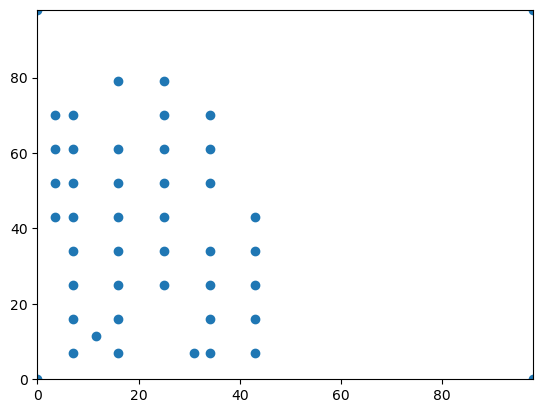

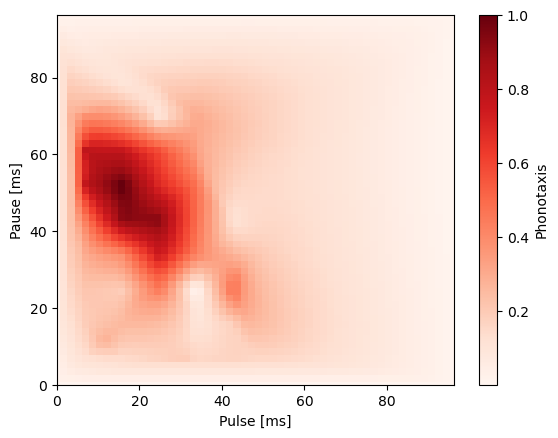

ADO
[13, 22, 1.4, -0.08, 0.23, 5]
0.14219429046556276


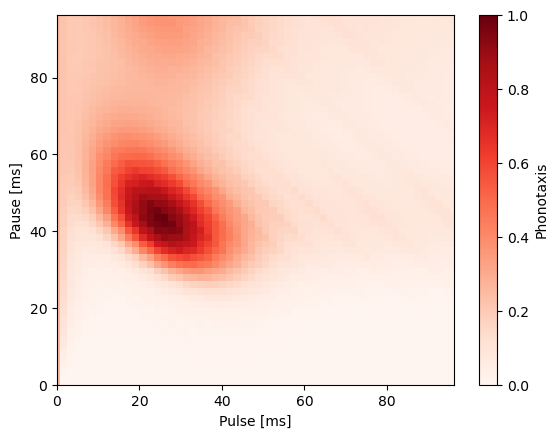

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.42194D-01    |proj g|=  1.82862D-01

At iterate    1    f=  1.41381D-01    |proj g|=  1.17832D-01

At iterate    2    f=  1.40875D-01    |proj g|=  6.79747D-02

At iterate    3    f=  1.40235D-01    |proj g|=  5.86729D-02

At iterate    4    f=  1.39583D-01    |proj g|=  5.12261D-02

At iterate    5    f=  1.38961D-01    |proj g|=  6.03310D-02

At iterate    6    f=  1.37516D-01    |proj g|=  3.79941D-02

At iterate    7    f=  1.37453D-01    |proj g|=  1.69826D-02

At iterate    8    f=  1.37436D-01    |proj g|=  4.87040D-03

At iterate    9    f=  1.37432D-01    |proj g|=  4.79915D-03

At iterate   10    f=  1.37400D-01    |proj g|=  9.05866D-03

At iterate   11    f=  1.37341D-01    |proj g|=  2.03383D-02

At iterate   12    f=  1.37186D-01    |proj g|=  3.84226D-02

At iterate   13    f=  1.3


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   54    f=  1.32586D-01    |proj g|=  4.19038D-02

At iterate   55    f=  1.32585D-01    |proj g|=  4.09280D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   56    f=  1.32585D-01    |proj g|=  4.09208D-02

At iterate   57    f=  1.32585D-01    |proj g|=  4.09204D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     57    182     59     0     0   4.092D-02   1.326D-01
  F =  0.13258477632288143     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80907D-01    |proj g|=  8.75172D-01

At iterate    1    f=  2.58567D-01    |proj g|=  2.90335D-01

At iterate    2    f=  1.57898D-01    |proj g|=  8.64477D-01

At iterate    3    f=  1.38810D-01    |proj g|=  2.38537D-01

At iterate    4    f=  1.37003D-01    |proj g|=  5.48475D-02

At iterate    5    f=  1.36706D-01    |proj g|=  8.19943D-02

At iterate    6    f=  1.36035D-01    |proj g|=  5.67592D-02

At iterate    7    f=  1.35749D-01    |proj g|=  5.89777D-02

At iterate    8    f=  1.35194D-01    |proj g|=  7.25300D-02

At iterate    9    f=  1.34517D-01    |proj g|=  1.36179D-01

At iterate   10    f=  1.33696D-01    |proj g|=  1.17173D-01

At iterate   11    f=  1.33078D-01    |proj g|=  3.82741D-02

At iterate   12    f=  1.32931D-01    |proj g|=  2.23353D-02

At iterate   13    f=  1.3


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   31    f=  1.32520D-01    |proj g|=  7.14119D-03

At iterate   32    f=  1.32520D-01    |proj g|=  7.07415D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   33    f=  1.32520D-01    |proj g|=  7.06695D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33    158     36     0     0   7.067D-03   1.325D-01
  F =  0.13252002824916176     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.73621D-01    |proj g|=  2.00011D-01

At iterate    1    f=  1.36513D-01    |proj g|=  1.08610D-01

At iterate    2    f=  1.36170D-01    |proj g|=  1.37496D-01

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   26    f=  1.32434D-01    |proj g|=  5.81003D-03

At iterate   27    f=  1.32434D-01    |proj g|=  2.94407D-03

At iterate   28    f=  1.32434D-01    |proj g|=  2.84962D-03

At iterate   29    f=  1.32433D-01    |proj g|=  3.75491D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   30    f=  1.32432D-01    |proj g|=  2.69858D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31    131     34     0     0   2.699D-03   1.324D-01
  F =  0.13243249737423315     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.93493D-01    |proj g|=  4.19581D-01

At iterate    1    f=  2.87246D-01    |proj g|=  1.13845D-01

At iterate    2    f=  2.86236D-01    |proj g|=  8.43874D-02

At iterate    3    f=  2.85102D-01    |proj g|=  9.70102D-02

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34    119     35     0     0   2.219D-03   1.324D-01
  F =  0.13240342908020841     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.04398D-01    |proj g|=  7.62744D-01

At iterate    1    f=  1.92457D-01    |proj g|=  4.22524D-01

At iterate    2    f=  1.65592D-01    |proj g|=  3.17979D-01

At iterate    3    f=  1.42521D-01    |proj g|=  9.20255D-01

At iterate    4    f=  1.38387D-01    |proj g|=  4.20820D-01

At iterate    5    f=  1.36129D-01    |proj g|=  2.17194D-01

At iterate    6    f=  1.35633D-01    |proj g|=  1.96793D-01

At iterate    7    f=  1.35394D-01    |proj g|=  1.76823D-02

At iterate    8    f=  1.35365D-01    |proj g|=  1.86240D-02

At iterate    9    f=  1.35315D-01    |proj g|=  2.50768D-02

At iterate   10    f=  1.35228D-01    |proj g|=  2.85288D-02

At iterate   11    f=  1.34725D-01    |proj g|=  1.33889D-02

At iterate   12    f=  1.34413D-01    |proj g|=  9.04546D-02

At iterate   13    f=  1.3


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   38    f=  1.32335D-01    |proj g|=  2.52547D-03

At iterate   39    f=  1.32335D-01    |proj g|=  2.21401D-03

At iterate   40    f=  1.32335D-01    |proj g|=  2.21359D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40    130     41     0     0   2.214D-03   1.323D-01
  F =  0.13233484315414201     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.17541D-01    |proj g|=  1.30198D+00

At iterate    1    f=  2.88221D-01    |proj g|=  4.36298D-03

At iterate    2    f=  2.00032D-01    |proj g|=  3.99304D-01

At iterate    3    f=  1.99998D-01    |proj g|=  3.84972D-01

At iterate    4    f=  1.45563D-01    |proj g|=  5.86442D-01

At iterate    5    f=  1.42694D-01    |proj g|=  1.05276D-01

At iterate    6    f=  1.38000D-01    |proj g|=  1.61315D-01

At iterate    7    f=  1.35929D-01    |proj g|=  4.70373D-02

At iterate    8    f=  1.35052D-01    |proj g|=  3.76292D-02

At iterate    9    f=  1.34519D-01    |proj g|=  5.12778D-02

At iterate   10    f=  1.33957D-01    |proj g|=  1.08770D-01

At iterate   11    f=  1.33364D-01    |proj g|=  8.71673D-02

At iterate   12    f=  1.33026D-01    |proj g|=  4.08419D-02

At iterate   13    f=  1.3


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   49    f=  1.32408D-01    |proj g|=  2.38702D-03

At iterate   50    f=  1.32408D-01    |proj g|=  9.57348D-04

At iterate   51    f=  1.32408D-01    |proj g|=  9.60024D-04

At iterate   52    f=  1.32407D-01    |proj g|=  2.64420D-03

At iterate   53    f=  1.32407D-01    |proj g|=  3.00842D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     54    186     56     0     0   3.008D-03   1.324D-01
  F =  0.13240735302196699     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.88425D-01    |proj g|=  1.60203D-03

At iterate    1    f=  2.88422D-01    |proj g|=  1.62108D-03
  ys=-3.458E-08  -gs= 3.040E-06 BFGS update SKIPPED

At iterate    2    f=  1.55603D-01    |proj g|=  4.70841D-01
  ys=-1.946E-01  -gs= 8.573E-04 BFGS update SKIPPED

At iterate    3    f=  1.52365D-01    |proj g|=  2.81898D-01

At iterate    4    f=  1.50561D-01    |proj g|=  2.84712D-01

At iterate    5    f=  1.43554D-01    |proj g|=  7.65530D-01

At iterate    6    f=  1.40967D-01    |proj g|=  7.79810D-02

At iterate    7    f=  1.40506D-01    |proj g|=  3.14659D-02

At iterate    8    f=  1.40286D-01    |proj g|=  3.15326D-02

At iterate    9    f=  1.39862D-01    |proj g|=  3.14793D-02

At iterate   10    f=  1.38703D-01    |proj g|=  3.79632D-02

At iterate   11    f=  1.37550D-01    |proj g|

/tmp/ipykernel_10629/901067433.py:6: RuntimeWarning: overflow encountered in exp
  g1 = 1/(1 + np.exp( -(a1 * f1) + b1)) # nonlinear sigmoid function



At iterate   15    f=  2.20194D-01    |proj g|=  1.15098D+00

At iterate   16    f=  1.74557D-01    |proj g|=  6.51776D-01

At iterate   17    f=  1.49083D-01    |proj g|=  3.60728D-02

At iterate   18    f=  1.48444D-01    |proj g|=  2.73250D-01

At iterate   19    f=  1.47855D-01    |proj g|=  2.80941D-01

At iterate   20    f=  1.44083D-01    |proj g|=  3.67166D-01

At iterate   21    f=  1.43266D-01    |proj g|=  3.02126D-02

At iterate   22    f=  1.42661D-01    |proj g|=  6.51515D-02

At iterate   23    f=  1.40587D-01    |proj g|=  1.93203D-01

At iterate   24    f=  1.38588D-01    |proj g|=  8.81940D-02

At iterate   25    f=  1.38191D-01    |proj g|=  3.48956D-01

At iterate   26    f=  1.38184D-01    |proj g|=  3.88679D-01

At iterate   27    f=  1.38181D-01    |proj g|=  4.10486D-01

At iterate   28    f=  1.38181D-01    |proj g|=  4.18377D-01

At iterate   29    f=  1.38178D-01    |proj g|=  4.57345D-01
  Positive dir derivative in projection 
  Using the backtracking step


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   55    f=  1.32319D-01    |proj g|=  4.53093D-03

At iterate   56    f=  1.32319D-01    |proj g|=  1.26444D-03

At iterate   57    f=  1.32319D-01    |proj g|=  2.00795D-03

At iterate   58    f=  1.32318D-01    |proj g|=  4.65443D-03

At iterate   59    f=  1.32318D-01    |proj g|=  5.41805D-03

At iterate   60    f=  1.32318D-01    |proj g|=  3.38766D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   61    f=  1.32318D-01    |proj g|=  4.58705D-04

At iterate   62    f=  1.32318D-01    |proj g|=  3.49296D-04

At iterate   63    f=  1.32318D-01    |proj g|=  3.44022D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     64    232     69     0     0   3.440D-04   1.323D-01
  F =  0.13231754527001377     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.64196D-01    |proj g|=  9.28449D-01

At iterate    1    f=  2.88595D-01    |proj g|=  5.38802D-04

At iterate    2    f=  2.65209D-01    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      2      9      3     0     0   0.000D+00   2.652D-01
  F =  0.26520852686939300     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


In [ ]:
func_call()